In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
df = pd.read_csv("..\Data\Alcohol_Sales.csv", index_col='DATE', parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['Sales']

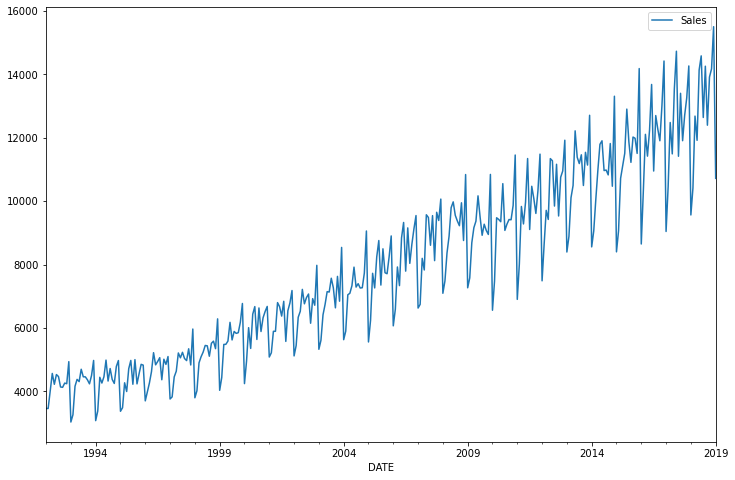

In [5]:
df.plot(figsize=(12, 8));

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
results = seasonal_decompose(df['Sales'])

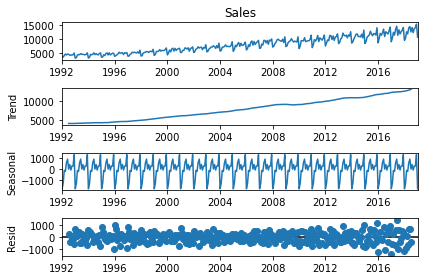

In [8]:
results.plot();

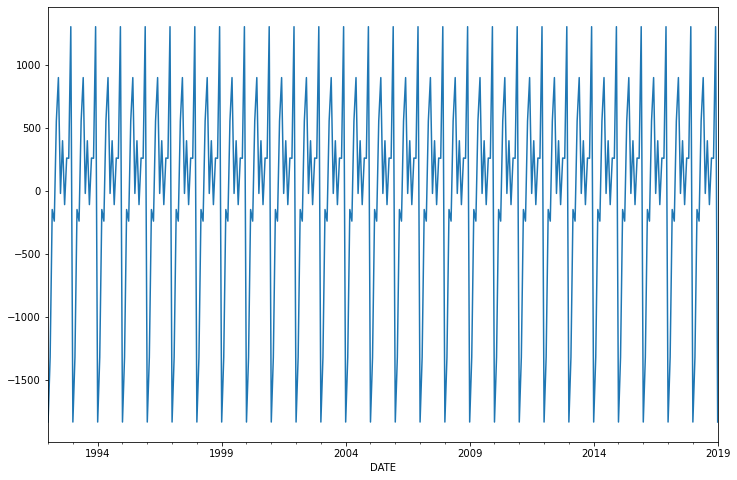

In [9]:
results.seasonal.plot(figsize=(12, 8));

In [10]:
train = df.iloc[:(len(df) - 12)]
test = df.iloc[(len(df) - 12):]

In [11]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [12]:
ser = np.array([23, 56, 2, 13, 14])

In [13]:
ser.max()

56

In [14]:
ser / ser.max()

array([0.41071429, 1.        , 0.03571429, 0.23214286, 0.25      ])

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [20]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [22]:
len(scaled_train)


313

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [28]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input,
                                batch_size=1) # features are target from same data source

In [29]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit_generator(train_generator, epochs=25)

Epoch 1/25
301/301 [==============================] - 6s 20ms/step - loss: 0.0147

In [32]:
model.history.history.keys()

dict_keys(['loss'])

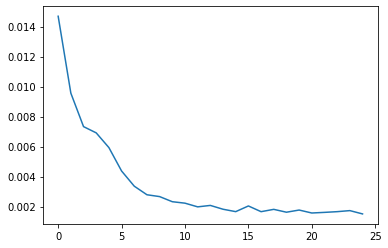

In [34]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss']);

In [35]:
first_eval_batch = scaled_train[-12:]

In [36]:
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [38]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [39]:
model.predict(first_eval_batch)

array([[0.709129]], dtype=float32)

In [ ]:
# Forecast using RNN model

In [40]:
# Hold predictions
test_predictions = []

# Last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]

# Reshape to format RNN wants
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# How far into the future do we forecast
for i in range(len(test)):

    # One timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]

    # Store the prediction
    test_predictions.append(current_pred)

    # Update current batch to include prediction. Remove first prediction from current_batch, add new prediction to the end
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [41]:
test_predictions

[array([0.709129], dtype=float32),
 array([0.8348658], dtype=float32),
 array([0.7896834], dtype=float32),
 array([0.95298177], dtype=float32),
 array([1.0271238], dtype=float32),
 array([0.7791679], dtype=float32),
 array([0.9263663], dtype=float32),
 array([0.79816645], dtype=float32),
 array([0.8743578], dtype=float32),
 array([0.9187363], dtype=float32),
 array([0.99073064], dtype=float32),
 array([0.6219236], dtype=float32)]

In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

In [43]:
true_predictions

array([[11327.09988868],
       [12798.09509349],
       [12269.50611514],
       [14179.93372768],
       [15047.32143986],
       [12146.48515153],
       [13868.55968523],
       [12368.74934345],
       [13260.112131  ],
       [13779.29572815],
       [14621.55779564],
       [10306.88449436]])

In [44]:
test['Predictions'] = true_predictions

C:\Users\User\.virtualenvs\Unit4-Sprint2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,11327.099889
2018-03-01,12683,12798.095093
2018-04-01,11919,12269.506115
2018-05-01,14138,14179.933728
2018-06-01,14583,15047.321440
2018-07-01,12640,12146.485152
2018-08-01,14257,13868.559685
2018-09-01,12396,12368.749343
2018-10-01,13914,13260.112131


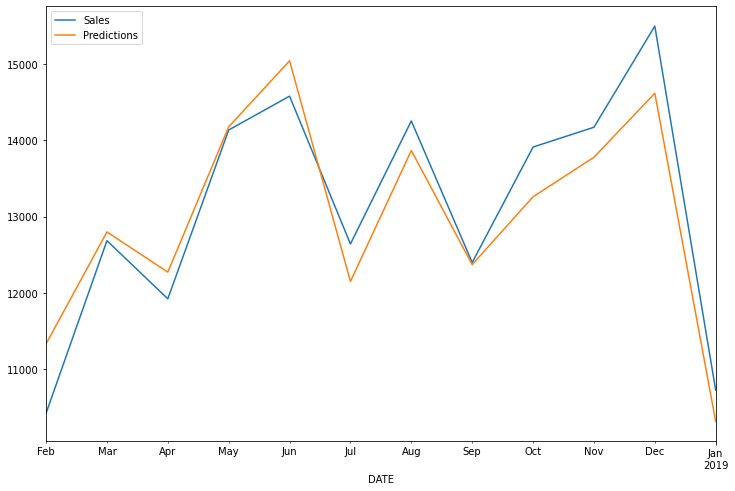

In [47]:
test.plot(figsize=(12, 8));

In [48]:
model.save('mycoolmodel.h5')

In [51]:
from keras.models import load_model


In [52]:
new_model = load_model('mycoolmodel.h5')

In [53]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________
